Datasets can be downloaded [here](https://www.dropbox.com/sh/gf3ivaufcl43mqh/AADBQVBD99TkIcf_eLHyuIfDa?dl=0)  

Ref: Buenrostro, J.D. et al. Integrated Single-Cell Analysis Maps the Continuous Regulatory Landscape of Human Hematopoietic Differentiation. Cell (2018).

In [2]:
import stream as st
st.__version__

'1.0'

In [3]:
st.set_figure_params(dpi=80,style='white',figsize=[5.4,4.8],
                     rc={'image.cmap': 'viridis'})

In [4]:
import stream_atac
stream_atac.__version__

'0.3.5'

For scATAC-seq analysis, STREAM can take as input a feature matrix, 

- e.g. k-mer feature matrix
- e.g. motif feature matrix

More details can be found https://github.com/pinellolab/STREAM_atac

In [5]:
adata = stream_atac.preprocess_atac(file_count='./count_file.tsv.gz',
                                    file_region='./region_file.bed.gz',
                                    file_sample='./sample_file.tsv.gz',
                                    genome = 'hg19',
                                    feature='motif',
                                    workdir='./motif_result')

Checking if required packages are installed ...


/Users/huidong/anaconda3/envs/test_steam/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)


Saving results in: ./motif_result
Running chromVAR pipeline ...


In [6]:
st.add_cell_labels(adata,file_name='./cell_label.tsv.gz')
st.add_cell_colors(adata,file_name='./cell_label_color.tsv.gz')

In [7]:
adata.shape

(2034, 386)

using all the features ...
60 PCs are selected


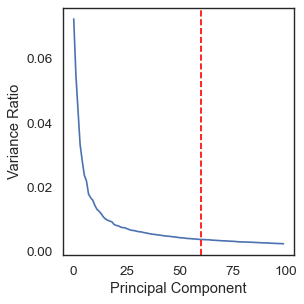

In [8]:
st.select_top_principal_components(adata,n_pc=60,first_pc=True)

In [9]:
st.dimension_reduction(adata,method='se',feature='top_pcs',n_components=5,n_neighbors=30,n_jobs=4)

feature top_pcs is being used ...
4 cpus are being used ...


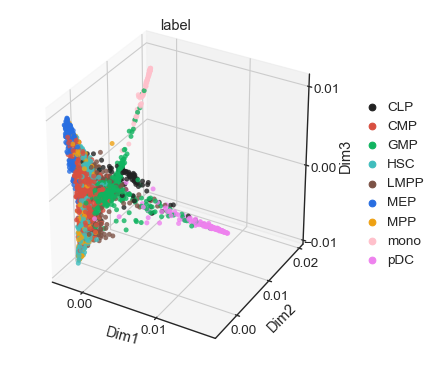

In [10]:
st.plot_dimension_reduction(adata,color=['label'],n_components=3,show_graph=False,show_text=False,plotly=False)

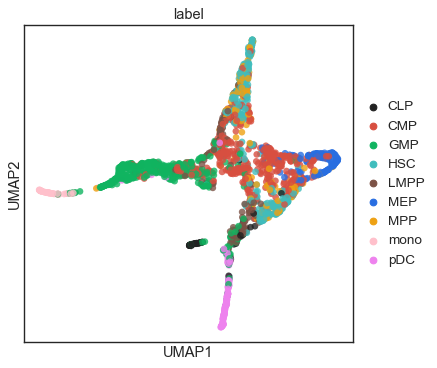

In [11]:
st.plot_visualization_2D(adata,n_neighbors=100,color=['label'],use_precomputed=False)

#### Trajectory inference

* By default, trajectories will be inferred in **the manifold learnt from the step of dimension reduction `st.dimension_reduction()`**


* But it can be also learned directly on **2D visualization plot from `st.plot_visualization_2D()`** by setting `use_vis=True` in st.seed_elastic_principal_graph(). An example can be found [here](https://nbviewer.jupyter.org/github/pinellolab/STREAM/blob/master/tutorial/1.2.use_vis.ipynb)

Here we infer trajectories on 2D visualization plot.

In [12]:
st.seed_elastic_principal_graph(adata,n_clusters=10,use_vis=True)

Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
The number of initial nodes is 10
Calculatng minimum spanning tree...
Number of initial branches: 4


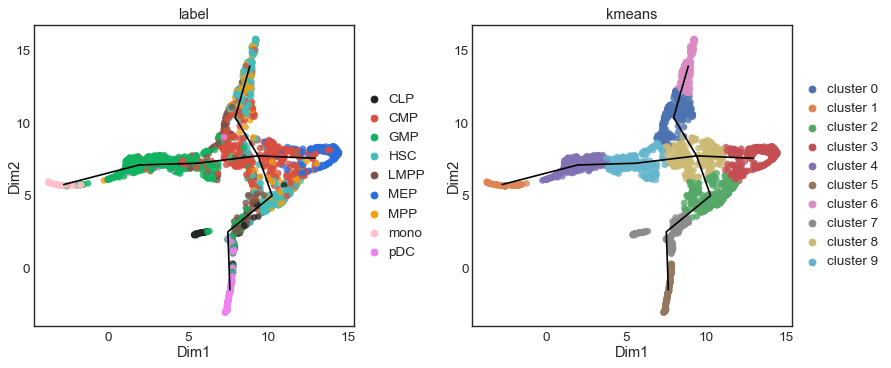

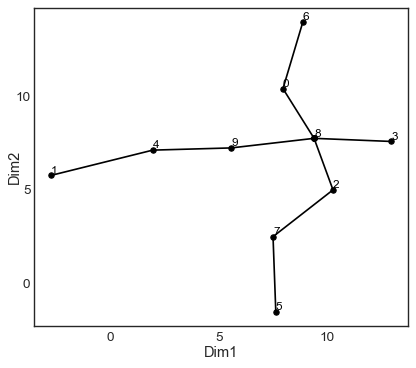

In [13]:
st.plot_dimension_reduction(adata,color=['label','kmeans'],n_components=2,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=True)

**`epg_alpha`, `epg_mu`, `epg_lambda` are the three most influential parameters for learning elastic principal graph.**  
- `epg_alpha`: penalizes spurious branching events. **The larger, the fewer branches the function will learn**. (by default, `epg_alpha=0.02`)
- `epg_mu`: penalizes the deviation from harmonic embedding, where harmonicity assumes that each node is the mean of its neighbor nodes. **The larger, the more edges the function will use to fit into points(cells)** (by default, `epg_mu=0.1`) 
- `epg_lambda`: penalizes the total length of edges. **The larger, the 'shorter' curves the function will use to fit into points(cells)** and the fewer points(cells) the curves will reach. (by default, `epg_lambda=0.02`)

> **'epg_trimmingradius'** can help get rid of noisy points (by defalut `epg_trimmingradius=Inf`)   
e.g. `st.elastic_principal_graph(adata,epg_trimmingradius=0.1)`  

In [14]:
st.elastic_principal_graph(adata,epg_alpha=0.01,epg_mu=0.05,epg_lambda=0.01)

Learning elastic principal graph...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 50 nodes on 2034 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
10
 
11
 
12
 
13
 
14
 
15
 
16
 
17
 
18
 
19
 
20
 
21
 
22
 
23
 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1|1||50
	
0.6465
	
50
	
49
	
43
	
1
	
0
	
0
	
0.2571
	
0.2104
	
0.9906
	
0.9923
	
0.332
	
0.0574
	
2.87
	
143.5
	
0


12.234 sec elapsed

[[1]]



Number of branches after learning elastic principal graph: 6


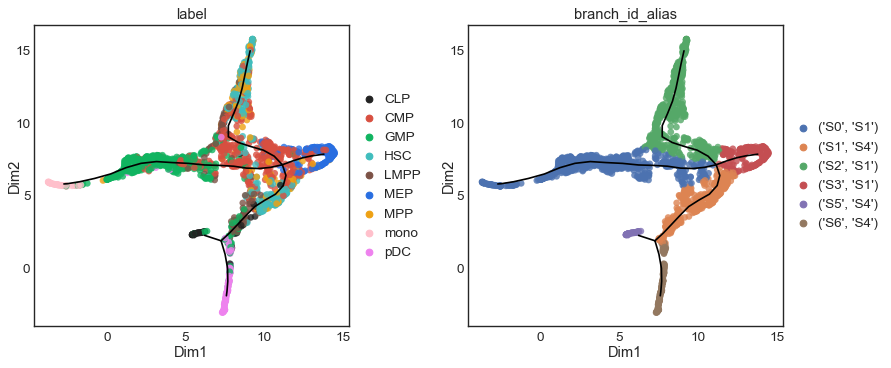

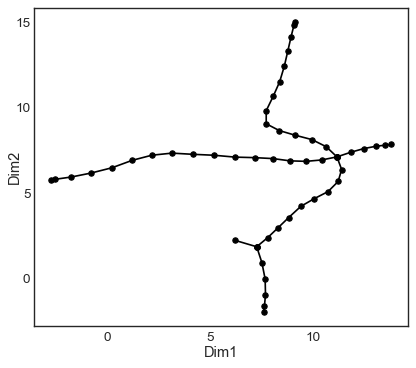

In [15]:
st.plot_dimension_reduction(adata,color=['label','branch_id_alias'],n_components=2,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=False)

Extending leaves with additional nodes ...
Number of branches after extending leaves: 6


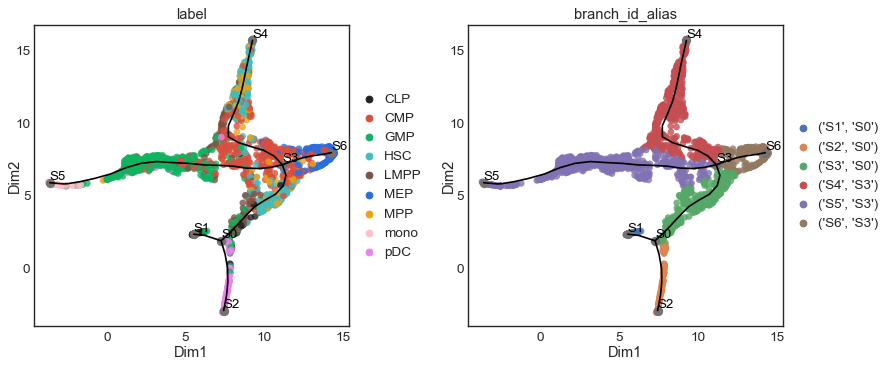

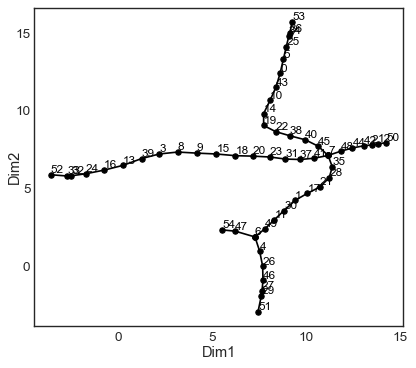

In [16]:
###Extend leaf branch to reach further cells 
st.extend_elastic_principal_graph(adata, epg_ext_mode='WeigthedCentroid',epg_ext_par=0.8)
st.plot_dimension_reduction(adata,color=['label','branch_id_alias'],n_components=2,show_graph=True,show_text=True)
st.plot_branches(adata,show_text=True)

Importing precomputed umap visualization ...


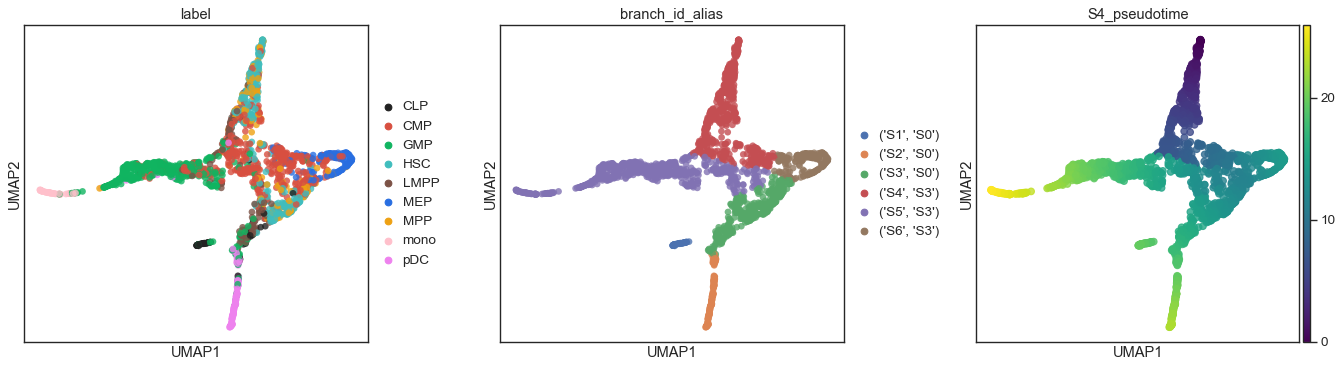

In [17]:
st.plot_visualization_2D(adata,n_neighbors=100,color=['label','branch_id_alias','S4_pseudotime'])

#### Trajectory visualization

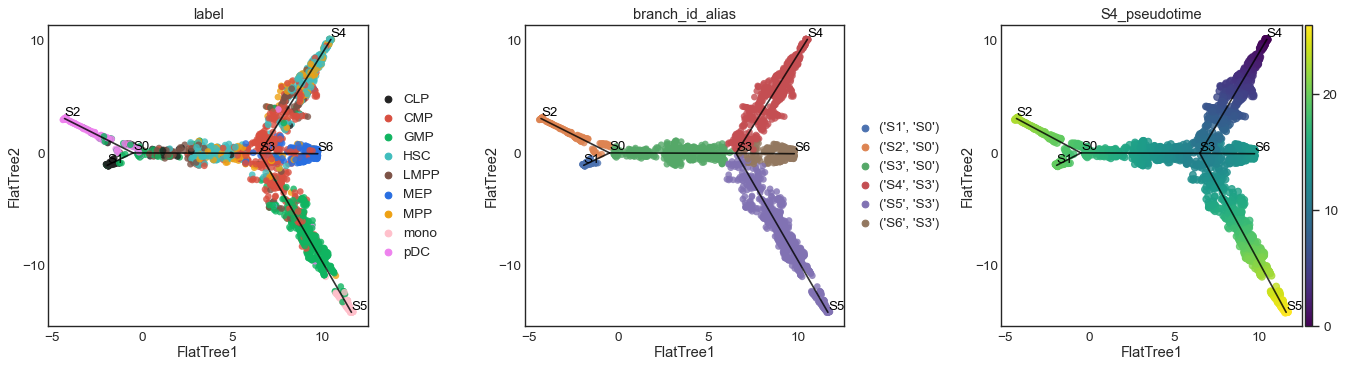

In [18]:
st.plot_flat_tree(adata,color=['label','branch_id_alias','S4_pseudotime'],
                  dist_scale=1,show_graph=True,show_text=True)

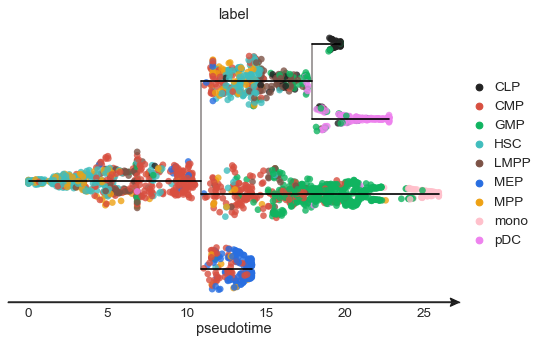

In [19]:
st.plot_stream_sc(adata,root='S4',color=['label'],
                  dist_scale=0.5,show_graph=True,show_text=False)

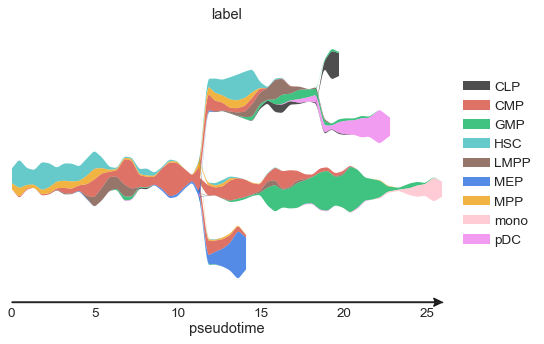

In [20]:
st.plot_stream(adata,root='S4',color=['label'])

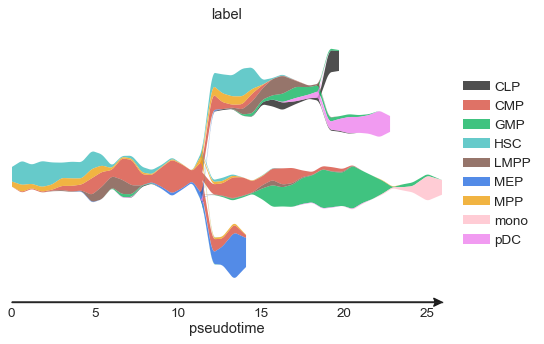

In [21]:
st.plot_stream(adata,root='S4',color=['label'],factor_min_win=1.5)

#### Detect marker motifs for each leaf branch

In [22]:
st.detect_leaf_markers(adata,root='S4')

Scanning all features ...
Filtering out markers that are expressed in less than 5 cells ...
1 cpus are being used ...
386 markers are being scanned ...


In [23]:
adata.uns['leaf_markers_all']

,zscore,H_statistic,H_pvalue,S4S3_pvalue,S0S1_pvalue,S0S2_pvalue,S3S5_pvalue,S3S6_pvalue
MA0102.3_CEBPA,1.94836,1015.12,1.88596e-218,7.30187e-256,3.36058e-73,1.11681e-102,1,2.10555e-240
MA0080.4_SPI1,1.30552,1009.69,2.8338e-217,9.08008e-151,7.24752e-37,1,1.83471e-12,9.86541e-207
MA0838.1_CEBPG,1.94399,959.174,2.51013e-206,1.22591e-244,2.37673e-77,2.21098e-89,1,3.79427e-195
MA0140.2_GATA1::TAL1,1.87563,956.6,9.06931e-206,3.21546e-65,2.65799e-89,2.42288e-225,8.81569e-212,1
MA0837.1_CEBPE,1.95733,946.706,1.26345e-203,9.15153e-235,6.03896e-69,4.15874e-97,1,1.20375e-195
...,...,...,...,...,...,...,...,...
MA0865.1_E2F8,1.91363,35.105,4.42033e-07,3.4113e-06,1,4.62964e-05,5.52711e-06,0.00631556
MA0158.1_HOXA5,1.56613,28.7287,8.87494e-06,0.00520922,0.000158665,5.98552e-05,0.00209183,1
MA0866.1_SOX21,1.86802,27.6324,1.48063e-05,2.23145e-05,0.00439132,2.23145e-05,8.32877e-05,1
MA0132.2_PDX1,1.76381,24.8366,5.42614e-05,0.000363038,0.0041392,0.000120945,0.0041392,1


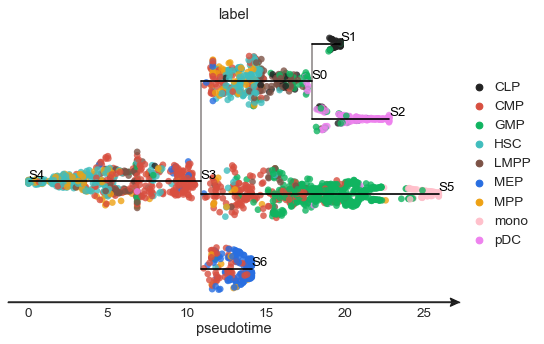

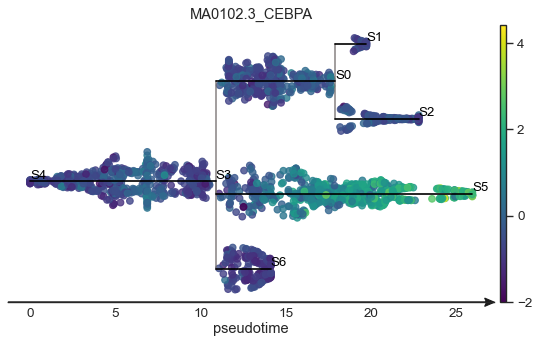

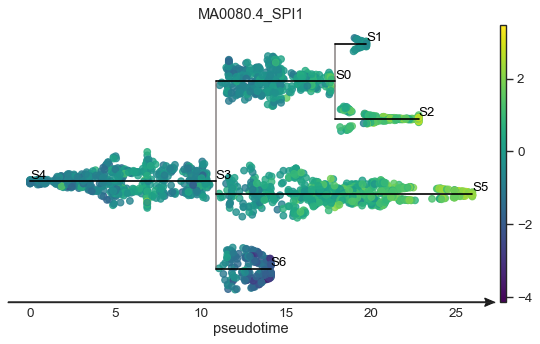

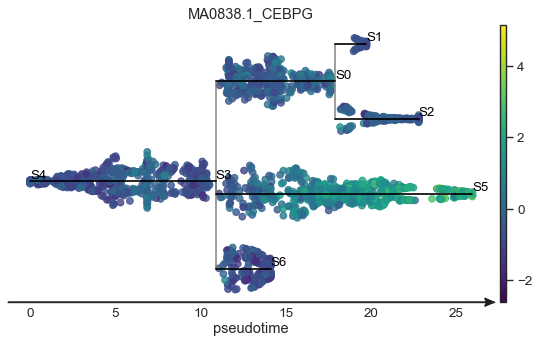

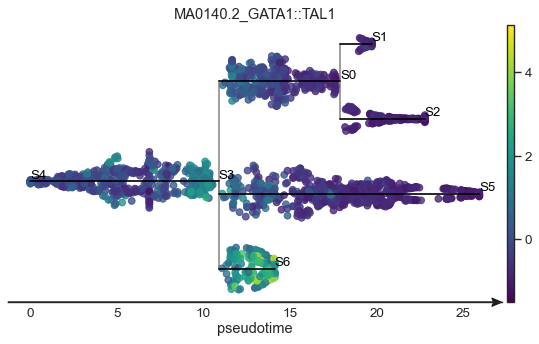

In [24]:
st.plot_stream_sc(adata,root='S4',color=['label','MA0102.3_CEBPA','MA0080.4_SPI1','MA0838.1_CEBPG','MA0140.2_GATA1::TAL1'],
                  dist_scale=0.5,show_graph=True,show_text=True)

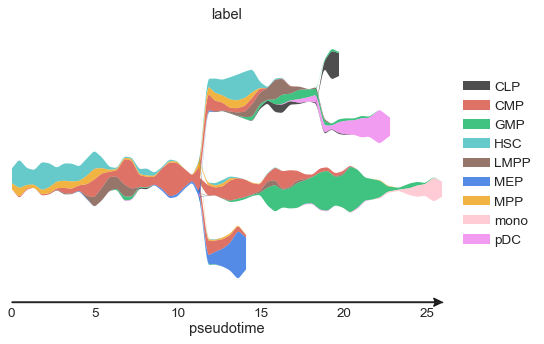

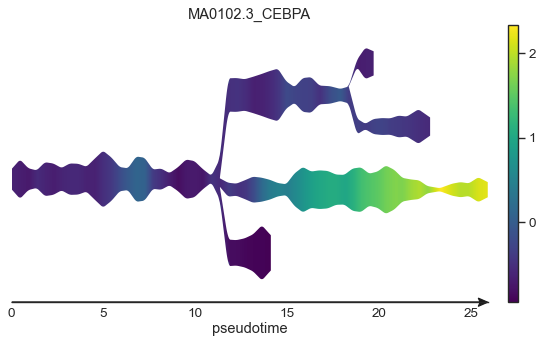

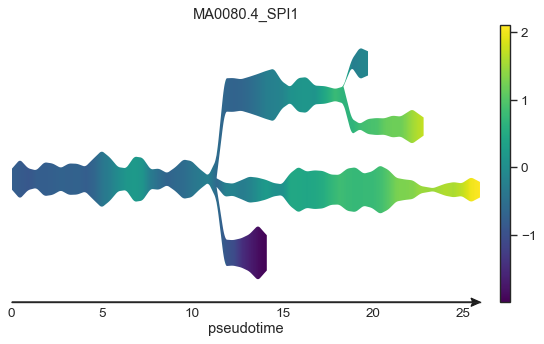

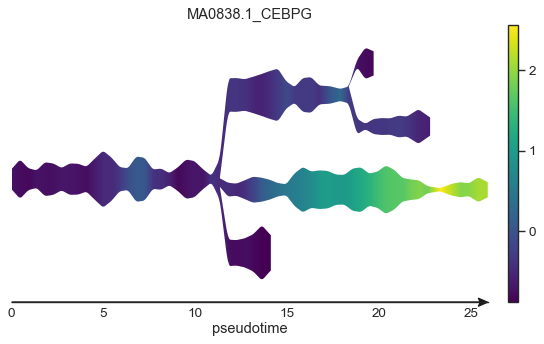

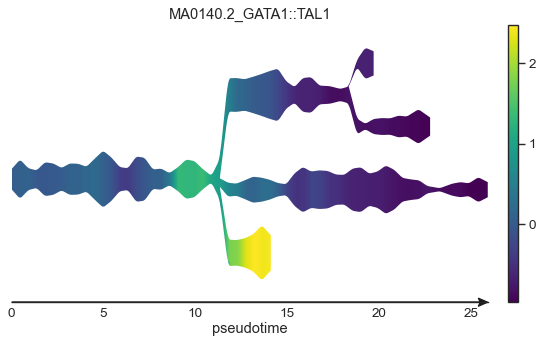

In [25]:
st.plot_stream(adata,root='S4',color=['label','MA0102.3_CEBPA','MA0080.4_SPI1','MA0838.1_CEBPG','MA0140.2_GATA1::TAL1'])

#### Save results

In [27]:
st.write(adata,file_name='stream_atac_motifs.pkl')